In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm
from torch.utils.data import Dataset, DataLoader
from utils.networks_2 import *
from utils.data import Loader32
import torch.optim as optim
from tqdm import tqdm
from utils.metrics import plot_tsne

In [9]:
num_epochs = 100
nz = 3
batch_size = 80
seq_len = 127
clip= 0.01
lr = 0.0002

if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"

device = torch.device(dev) 
device

device(type='cuda', index=0)

In [75]:
df = pd.read_csv('./data/GANData.csv')
actif = "UK Government Bond - USD Hedged"
sdf = df[df['ASSETNAME']==actif]['PRICE']
y = np.log(sdf/sdf.shift(1))[1:].to_numpy()
true_y = df[df['ASSETNAME']==actif]['PRICE'].to_numpy()
y.shape

(2494,)

In [108]:
num_epochs = 200
generator = Generator().to(device)
log_returns_preprocessed = np.expand_dims(y, axis=1)
train = True

if train:
    discriminator = Discriminator(seq_len).to(device)
    disc_optimizer = optim.RMSprop(discriminator.parameters(), lr=lr)
    gen_optimizer = optim.RMSprop(generator.parameters(), lr=lr)

    dataset = Loader32(log_returns_preprocessed, 127)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    dataset = Loader32(log_returns_preprocessed, 1)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    t = tqdm(range(num_epochs))
    for epoch in t:
        for idx, data in enumerate(dataloader, 0):

            discriminator.zero_grad()
            real = data.to(device)
            batch_size, seq_len = real.size(0), real.size(1)
            noise = torch.randn(batch_size, nz, seq_len, device=device)
            fake = generator(noise).detach()
            disc_loss = -torch.mean(discriminator(real)) + torch.mean(discriminator(fake))
            disc_loss.backward()
            disc_optimizer.step()

            for dp in discriminator.parameters():
                dp.data.clamp_(-clip, clip)
    
            if idx % 5 == 0:
                generator.zero_grad()
                gen_loss = -torch.mean(discriminator(generator(noise)))
                gen_loss.backward()
                gen_optimizer.step()            
        t.set_description('Discriminator Loss: %.8f Generator Loss: %.8f' % (disc_loss.item(), gen_loss.item()))
            
    # Save
    #torch.save(generator, f'{generator_path}trained_generator_{file_name}_epoch_{epoch}.pth')

else:
    # Load
    generator = torch.load(f'{generator_path}trained_generator_{file_name}_epoch_{num_epochs-1}.pth')
    generator.eval()


/home/onyxia/work/.venv/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
  0%|          | 0/200 [00:00<?, ?it/s]

Discriminator Loss: 0.00000000 Generator Loss: -0.49999857:  70%|███████   | 140/200 [53:11<22:47, 22.80s/it]  


KeyboardInterrupt: 

In [124]:
generator.eval()
noise = torch.randn(80,3,127).to(device)
z = generator(noise).cpu().detach().squeeze()

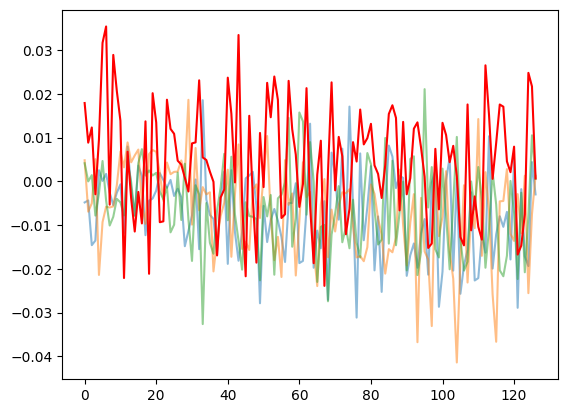

In [130]:
from utils.create_data import simple_plot
generator.eval()
noise = torch.randn(80,3,127).to(device)
z = generator(noise).cpu().detach().squeeze()
for i in range(3):
    plt.plot(z.numpy()[i]/5, alpha=0.5 ,label= f'scénario {i}')
plt.plot(y[:127], color='red')

In [131]:
def moving_window(x, length):
    return [x[i: i+ length] for i in range(0,(len(x)+1)-length, 10)]
augment_data= np.array(moving_window(y,127))

In [132]:
real = np.reshape(augment_data, (237,1,127))
idx = np.random.randint(augment_data.shape[0], size=80)
real_samples = real[idx,:,:]

In [133]:
fake = np.reshape(z.numpy(), (80,1,127))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 160 samples in 0.001s...
[t-SNE] Computed neighbors for 160 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 160 / 160
[t-SNE] Mean sigma: 0.046039
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.389671
[t-SNE] KL divergence after 300 iterations: 0.699596


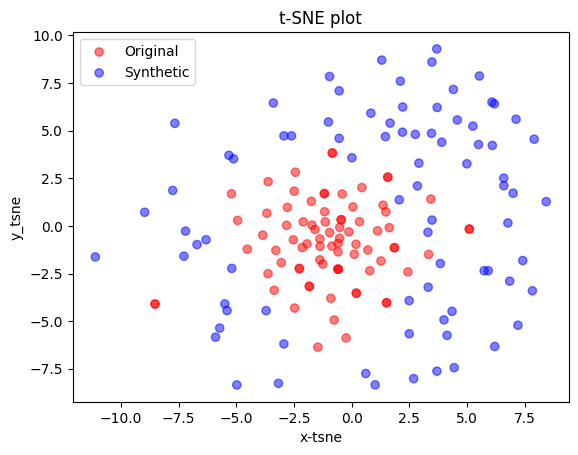

In [134]:
plot_tsne(real_samples, fake, random=False)